In [1]:
####
#Title: Stock_Model_LSTM
#Author: Guo Zebin

#Description: This is stock prediction model using ML models
#             Use LSTM and multiple features
#Evaluation: Using MSE
#Conclusion: LSTM performs far more better than lr and tree
#Discussion: 1. parameter adjustment? 2. does these features reasonable as training data?

In [19]:
#Import all the library used
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
#load the data from local environment
from google.colab import files
uploaded = files.upload()

Saving netflix.csv to netflix.csv


In [4]:
#store the data into df
df = pd.read_csv('netflix.csv')
df.tail(1000)

,Date,High,Low,Open,Close,Volume,Adj Close
3881,2017-10-20,196.380005,193.770004,195.899994,194.160004,5995600.0,194.160004
3882,2017-10-23,194.899994,191.029999,194.169998,192.470001,6980000.0,192.470001
3883,2017-10-24,196.740005,191.399994,192.750000,196.020004,7069100.0,196.020004
3884,2017-10-25,197.059998,193.009995,195.380005,193.770004,5315300.0,193.770004
3885,2017-10-26,197.610001,194.080002,194.660004,195.210007,5185800.0,195.210007
...,...,...,...,...,...,...,...
4876,2021-10-05,640.390015,606.890015,606.940002,634.809998,9534300.0,634.809998
4877,2021-10-06,639.869995,626.359985,628.179993,639.099976,4580400.0,639.099976
4878,2021-10-07,646.840027,630.450012,642.229980,631.849976,3556900.0,631.849976
4879,2021-10-08,643.799988,630.859985,634.169983,632.659973,3271100.0,632.659973


In [5]:
# get the size of data
df.shape

(4881, 7)

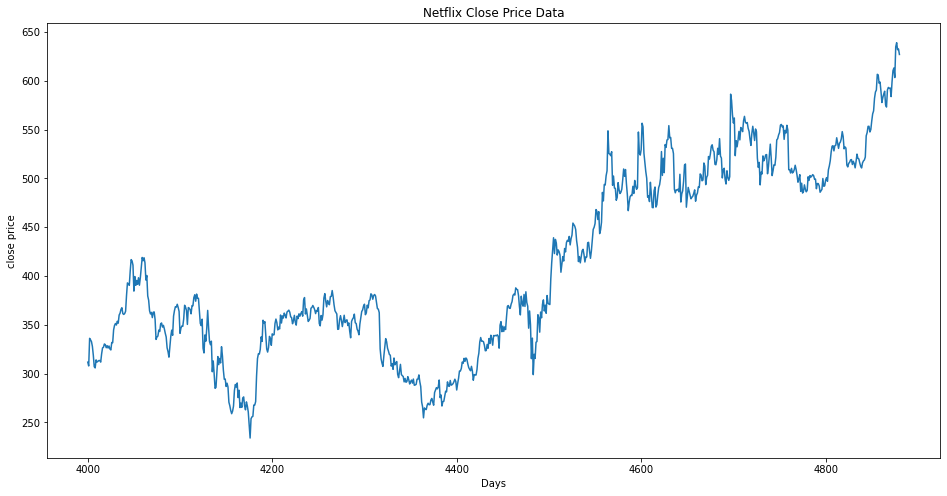

In [6]:
#visualise the close price data
plt.figure(figsize=(16,8))
plt.title('Netflix Close Price Data')
plt.xlabel('Days')
plt.ylabel('close price')
plt.plot(df['Close'][4000:])
plt.show()

In [7]:
# Get training part(Why choose 2018-01-01?)
df_training = df[df['Date'] < '2018-01-01']
df_training

,Date,High,Low,Open,Close,Volume,Adj Close
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429
...,...,...,...,...,...,...,...
3925,2017-12-22,190.949997,186.800003,188.330002,189.940002,3878900.0,189.940002
3926,2017-12-26,189.940002,186.399994,189.779999,187.759995,3045700.0,187.759995
3927,2017-12-27,188.100006,185.220001,187.800003,186.240005,4002100.0,186.240005
3928,2017-12-28,194.490005,186.850006,187.179993,192.710007,10107400.0,192.710007


In [8]:
# Get testing part
df_testing = df[df['Date'] >= '2018-01-01']
df_testing

,Date,High,Low,Open,Close,Volume,Adj Close
3930,2018-01-02,201.649994,195.419998,196.100006,201.070007,10966900.0,201.070007
3931,2018-01-03,206.210007,201.500000,202.050003,205.050003,8591400.0,205.050003
3932,2018-01-04,207.050003,204.000000,206.199997,205.630005,6029600.0,205.630005
3933,2018-01-05,210.020004,205.589996,207.250000,209.990005,7033200.0,209.990005
3934,2018-01-08,212.500000,208.440002,210.020004,212.050003,5580200.0,212.050003
...,...,...,...,...,...,...,...
4876,2021-10-05,640.390015,606.890015,606.940002,634.809998,9534300.0,634.809998
4877,2021-10-06,639.869995,626.359985,628.179993,639.099976,4580400.0,639.099976
4878,2021-10-07,646.840027,630.450012,642.229980,631.849976,3556900.0,631.849976
4879,2021-10-08,643.799988,630.859985,634.169983,632.659973,3271100.0,632.659973


In [9]:
# get rid of trashy features(Why drop adj close?idk)
Adj_training = df_training.drop(['Date','Adj Close'],1)
Adj_training.head()

,High,Low,Open,Close,Volume
0,1.242857,1.145714,1.156429,1.196429,104790000.0
1,1.225000,1.197143,1.214286,1.210000,11104800.0
2,1.232143,1.157143,1.213571,1.157143,6609400.0
3,1.164286,1.085714,1.164286,1.103571,6757800.0
4,1.107857,1.071429,1.107857,1.071429,10154200.0


In [10]:
# get rid of trashy features(Why drop adj close?)
Adj_testing = df_testing.drop(['Date','Adj Close'],1)
Adj_testing.shape

(951, 5)

In [11]:
# Feature scaling
scaler = MinMaxScaler()
Adj_training = scaler.fit_transform(Adj_training)
Adj_testing = scaler.fit_transform(Adj_testing)
Adj_training

array([[0.00407975, 0.00404203, 0.0038625 , 0.0040709 , 0.32341447],
       [0.0039922 , 0.00430211, 0.00414953, 0.00413798, 0.03348267],
       [0.00402722, 0.00409982, 0.00414598, 0.00387671, 0.01957055],
       ...,
       [0.92018407, 0.93491573, 0.92980184, 0.91873748, 0.01150162],
       [0.95151231, 0.94315876, 0.92672596, 0.95071856, 0.03039597],
       [0.94886481, 0.96525806, 0.95316812, 0.94701133, 0.01517044]])

In [12]:
X_train = []
y_train = []
X_test = []
y_test = []

In [ ]:
Adj_training.shape

In [13]:
# Create training set
for i in range(60, Adj_training.shape[0]):
  X_train.append(Adj_training[i-60:i])
  y_train.append(Adj_training[i, 0])

In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
print(X_train.shape)

(3870, 60, 5)


In [16]:
# Create testing set
for i in range(60, Adj_testing.shape[0]):
  X_test.append(Adj_testing[i-60:i])
  y_test.append(Adj_testing[i, 0])

In [17]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [20]:
# create LSTM model(figure out what each parameters are doing IMPORTANT!)
model = Sequential()
layer = Dropout(0.2)
model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(layer)
model.add(LSTM(units = 50, activation='relu', return_sequences = True))
model.add(layer)
model.add(LSTM(units = 50, activation='relu', return_sequences = True))
model.add(layer)
model.add(LSTM(units = 50, activation='relu'))
model.add(layer)

model.add(Dense(units = 1))

In [ ]:
model.summary()

In [ ]:
#Now do the trainging(this is one of the judgement of parameter adjustment)
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train,y_train,epochs = 20,batch_size = 32)

In [ ]:
X_test.shape

In [ ]:
# Do the prediction
y_predict = model.predict(X_test)
y_predict

In [ ]:
# Feature scaling(Why use .scale_  here?)
scale = scaler.scale_[0]
scale

In [ ]:
y_predict = y_predict / scale
y_test = y_test / scale
y_test.shape

In [ ]:
##visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('predict price')
plt.plot(y_test, color = 'red', label = 'Real price')
plt.plot(y_predict, color = 'green', label = 'Predicted price')
plt.legend()
plt.show()

In [ ]:
# The MSE of data (another judgement of parameter adjustment)
print('MSE:')
print(mean_squared_error(y_test*scale, y_predict*scale)/891*638.7271185815334)